In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
plt.rcParams["figure.figsize"] = (20,8)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from pandas import DataFrame
from sklearn import preprocessing
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import os
import random

import plotly
from chart_studio import plotly as py
import plotly.graph_objs as go
import chart_studio
chart_studio.tools.set_credentials_file(username='$username$',api_key='$apikey$')

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [237]:
df=pd.read_csv("CADCurve dep.csv")
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in df["Date"]]
df=df.iloc[:,1:]
df.index=x
df.head()

,1M,2M,3M,6M,9M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
1995-07-14,0.065547,0.06447,0.063373,0.06397,0.064241,0.064587,0.067764,0.069852,0.072227,0.074802,0.076541,0.078377,0.079875,0.081453,0.083113
1995-07-15,0.065547,0.06447,0.063373,0.06397,0.064241,0.064587,0.067764,0.069852,0.072227,0.074802,0.076541,0.078377,0.079875,0.081453,0.083113
1995-07-16,0.065547,0.06447,0.063373,0.06397,0.064241,0.064587,0.067764,0.069852,0.072227,0.074802,0.076541,0.078377,0.079875,0.081453,0.083113
1995-07-17,0.065547,0.06447,0.063373,0.06397,0.064241,0.064587,0.067764,0.069852,0.072227,0.074802,0.076541,0.078377,0.079875,0.081453,0.083113
1995-07-18,0.065547,0.06447,0.063373,0.06397,0.064241,0.064587,0.067764,0.069852,0.072227,0.074802,0.076541,0.078377,0.079875,0.081453,0.083113


## Multivariate time series forecasting for Multi-step using stacked LSTM sequence to sequence Autoencoder

In [248]:
def series_to_supervised(ts, lag, steps_ahead):
    X, y = [],[]
    for i in range(len(ts)):
        past_end = i + lag
        future_end = past_end + steps_ahead
        if future_end > len(ts):
            break
        past, future = ts[i:past_end, :], ts[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

def model1(lag, steps_ahead, n_features):
    os.environ['PYTHONHASHSEED'] = '42'
    np.random.seed(42)
    tf.random.set_seed(seed=42)
    np.random.RandomState(42)
    random.seed(42)
    
    
    #encoder part converts the given input sequence to a fixed-length vector,
    #which acts as a summary of the input sequence. The fixed length vector is also called context vector.
    encoder_inputs = tf.keras.layers.Input(shape=(lag, n_features))
    encoder_l1 = tf.keras.layers.LSTM(150, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]

    #decoder receives the context vector
    decoder_inputs = tf.keras.layers.RepeatVector(steps_ahead)(encoder_outputs1[0])
    decoder_l1 = tf.keras.layers.LSTM(150, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

    model_1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

    model_1.summary()
    print(encoder_l1.input_shape)
    print(encoder_l1.output_shape)
    print(np.asarray(encoder_outputs1[1:]).shape)
    return model_1

def model2(lag, steps_ahead, n_features):
    os.environ['PYTHONHASHSEED'] = '42'
    np.random.seed(42)
    tf.random.set_seed(seed=42)
    np.random.RandomState(42)
    random.seed(42)
    
    encoder_inputs = tf.keras.layers.Input(shape=(lag, n_features))
    encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]

    decoder_inputs = tf.keras.layers.RepeatVector(steps_ahead)(encoder_outputs2[0])

    decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
    decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

    model_2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

    model_2.summary()
    return model_2

In [239]:
# function for training
def training(lag,steps_ahead,n_features,model,path,train,val):
    X_train, y_train = series_to_supervised(train.values,lag, steps_ahead)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
    print(X_train.shape)
    print(y_train.shape)
    X_val, y_val = series_to_supervised(val.values,lag, steps_ahead)
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1],n_features))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], n_features))
    print(X_val.shape)
    print(y_val.shape)
    
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
    checkpoint1 = tf.keras.callbacks.ModelCheckpoint(path,
                                                     monitor='val_loss',
                                                     save_best_only=True,
                                                     mode='min')
    es=tf.keras.callbacks.EarlyStopping(patience=5)


    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
    history=model.fit(X_train,y_train,epochs=25,validation_data=(X_val,y_val),batch_size=32,callbacks=[reduce_lr,checkpoint1,es])
    
    plt.figure()
    plt.plot(np.arange(len(history.history['loss'])), history.history['loss'],
             color='r', label='Training loss')

    plt.plot(np.arange(len(history.history['loss'])),history.history['val_loss'],
             color='b', label='Validation loss')
    plt.title('Training vs Validation Loss (MAE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    
    
def testing(Xtest,X_input,path,model):
    
    model.load_weights(path)
    output=model.predict(X_input)
    output=output.reshape(output.shape[1],output.shape[2])
    c1=['1M_pred', '2M_pred', '3M_pred', '6M_pred', '9M_pred', '1Y_pred',
       '2Y_pred', '3Y_pred', '4Y_pred', '5Y_pred', '6Y_pred', '7Y_pred',
       '8Y_pred', '9Y_pred', '10Y_pred']
    c2=['1M', '2M', '3M', '6M', '9M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y',
       '8Y', '9Y', '10Y']
    output = pd.DataFrame(output)
    output.columns=c1
    Xtest= pd.DataFrame(Xtest)
    Xtest.columns=c2
    for i,j in zip(c1,c2):
        combine = pd.concat([output[i], Xtest[j]], axis=1)
        combine['MAPE'] = combine.apply(lambda row: abs(row[i]-row[j])/row[j] *100, axis = 1)
        combine['MAPE'] = pd.Series(["{}%".format(val) for val in combine['MAPE']],index = combine.index)
        combine = combine.reset_index()
        print(combine)
    return output, Xtest

 
def plot_errors(Xtest,X_input,path,model):
    
    model.load_weights(path)
    output=model.predict(X_input)
    output=output.reshape(output.shape[1],output.shape[2])
    c1=['1M_pred', '2M_pred', '3M_pred', '6M_pred', '9M_pred', '1Y_pred',
       '2Y_pred', '3Y_pred', '4Y_pred', '5Y_pred', '6Y_pred', '7Y_pred',
       '8Y_pred', '9Y_pred', '10Y_pred']
    c2=['1M', '2M', '3M', '6M', '9M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y',
       '8Y', '9Y', '10Y']
    output = pd.DataFrame(output)
    output.columns=c1
    Xtest= pd.DataFrame(Xtest)
    Xtest.columns=c2
    for i,j in zip(c1,c2):
        combine = pd.concat([output[i], Xtest[j]], axis=1)
        combine['MAPE'] = combine.apply(lambda row: abs(row[i]-row[j])/row[j] *100, axis = 1)
        combine['MAPE'] = pd.Series(["{}%".format(val) for val in combine['MAPE']],index = combine.index)
        combine = combine.reset_index()
        #print(combine)
        plt.plot(combine["MAPE"],label="MAPE plot for"+str(i))
        plt.legend()
        plt.show()
    
    
    
def errors(Xtest,X_input,path,model,output):
    c1=['1M_pred', '2M_pred', '3M_pred', '6M_pred', '9M_pred', '1Y_pred',
       '2Y_pred', '3Y_pred', '4Y_pred', '5Y_pred', '6Y_pred', '7Y_pred',
       '8Y_pred', '9Y_pred', '10Y_pred']
    c2=['1M', '2M', '3M', '6M', '9M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y',
       '8Y', '9Y', '10Y']
    Xtest= pd.DataFrame(Xtest)
    Xtest.columns=c2
    for k,j in zip(c1,c2):
        combine = pd.concat([output[k], Xtest[j]], axis=1)
        combine['MAPE'] = combine.apply(lambda row: row[k] /row[j] *100, axis = 1)
        combine['MAPE'] = pd.Series(["{0:.2f}%".format(val) for val in combine['MAPE']],index = combine.index)
        #combine = combine.reset_index()
        print(k,j)
        forecast_errors = [combine[j][i]- combine[k][i] for i in range(len(combine[j]))]
        bias = sum(forecast_errors) * 1.0/len(combine[j])
        print('Bias: %f' % bias)
        #print('R2 score:', r2_score(combine[j].values, combine[k].values))
        print('Mean absolute error:', mean_absolute_error(combine[j].values, combine[k].values))
        print('Mean squared error:', mean_squared_error(combine[j].values, combine[k].values))
        print('Root mean squared error:', np.sqrt(mean_squared_error(combine[j].values, combine[k].values)))


       
        
def plot_SwapCurves(output,X_test):
    for i in range(steps_ahead):
        plt.plot(output.iloc[i:i+1,].values[0],label="forecasted Swap curve for"+ str(i+1)+"th step ahead" )
        plt.plot(X_test.iloc[i:i+1,].values[0],label="Actual Swap curve for"+ str(i+1)+"th step ahead")
        plt.legend()
        plt.show()
        


Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 30, 15)]     0                                            
__________________________________________________________________________________________________
lstm_86 (LSTM)                  [(None, 150), (None, 99600       input_38[0][0]                   
__________________________________________________________________________________________________
repeat_vector_37 (RepeatVector) (None, 19, 150)      0           lstm_86[0][0]                    
__________________________________________________________________________________________________
lstm_87 (LSTM)                  (None, 19, 150)      180600      repeat_vector_37[0][0]           
                                                                 lstm_86[0][1]             

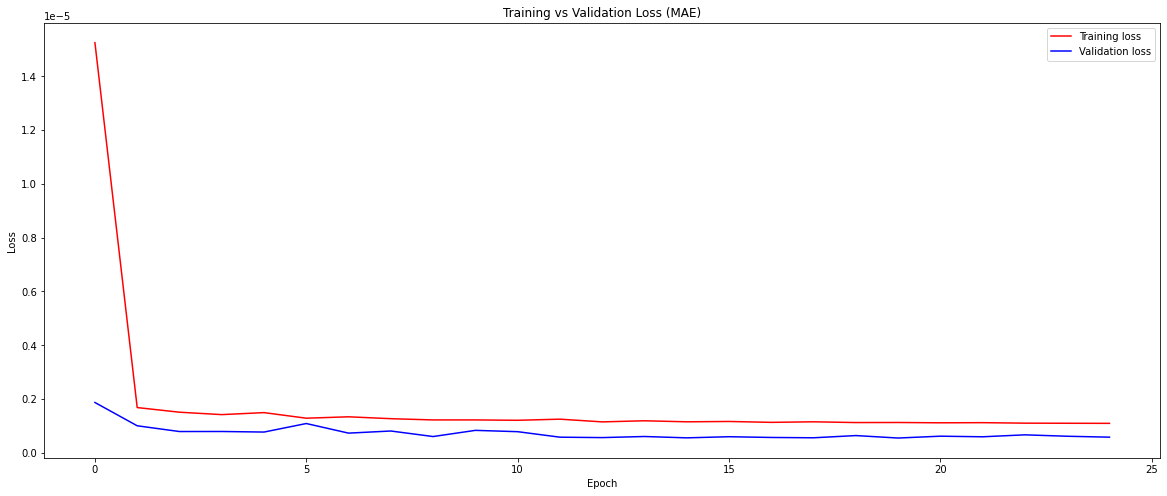

In [240]:
lag = 30
steps_ahead = 19
n_features = 15

train,val = df[1:7700], df[7700:-steps_ahead]

path1="best_weights1.hdf5"

model1=model1(lag, steps_ahead, n_features)

training(lag,steps_ahead,n_features,model1,path1,train,val)

## MAPE for different steps ahead

In [241]:
Xtest= df[-steps_ahead:].values
X_input=df[-(lag+steps_ahead):-steps_ahead].values
X_input=X_input.reshape(1,lag,n_features)
output,X_test=testing(Xtest,X_input,path1,model1)

    index   1M_pred        1M                 MAPE
0       0  0.004098  0.004175  1.8548959921933907%
1       1  0.004015  0.004175   3.825976088375386%
2       2  0.003984  0.004175   4.576811694099516%
3       3  0.003981  0.004175    4.65257785277452%
4       4  0.003990  0.004175   4.434168767072481%
5       5  0.004002  0.004175   4.147444103292361%
6       6  0.004012  0.004175  3.9045083308648185%
7       7  0.004019  0.004175   3.744320848030956%
8       8  0.004022  0.004175   3.666335130166148%
9       9  0.004023  0.004175  3.6525047110940143%
10     10  0.004021  0.004175   3.680221317057122%
11     11  0.004019  0.004175  3.7299773650255004%
12     12  0.004017  0.004175  3.7873959113023927%
13     13  0.004015  0.004175  3.8437883297126425%
14     14  0.004012  0.004175   3.895083569480985%
15     15  0.004010  0.004200   4.512228178126466%
16     16  0.004009  0.004200   4.552541140999107%
17     17  0.004007  0.004200  4.5903151411385705%
18     18  0.004006  0.004200  

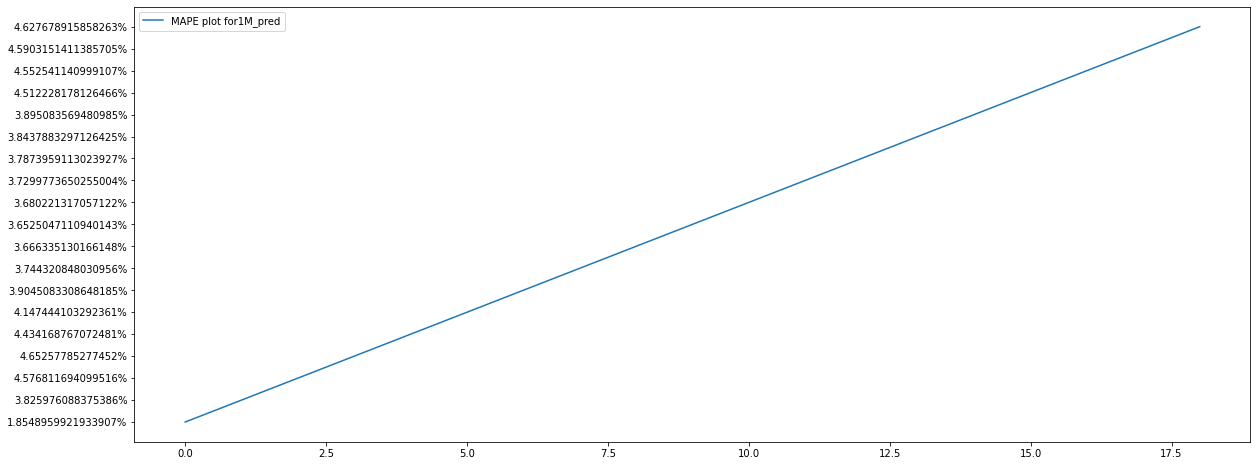

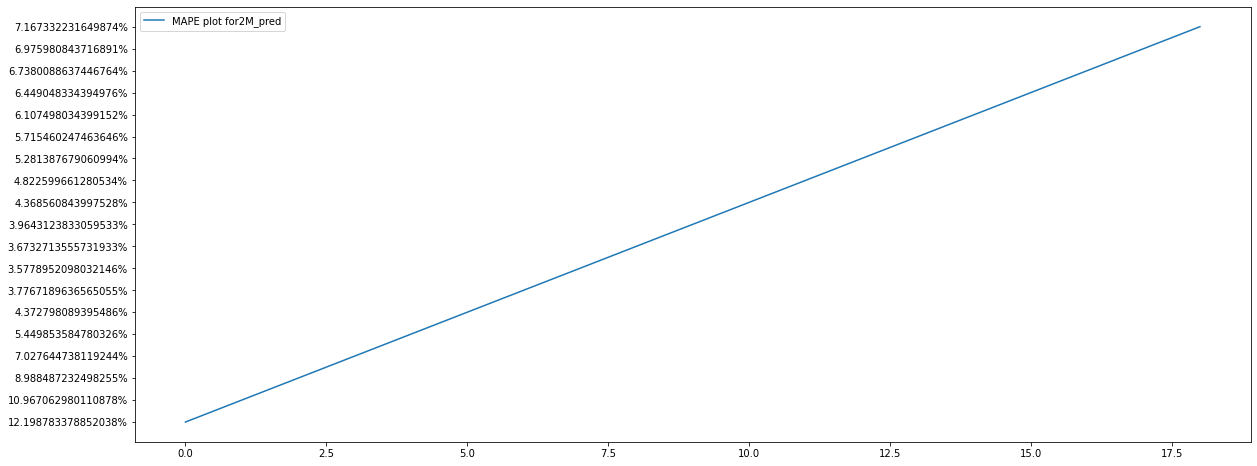

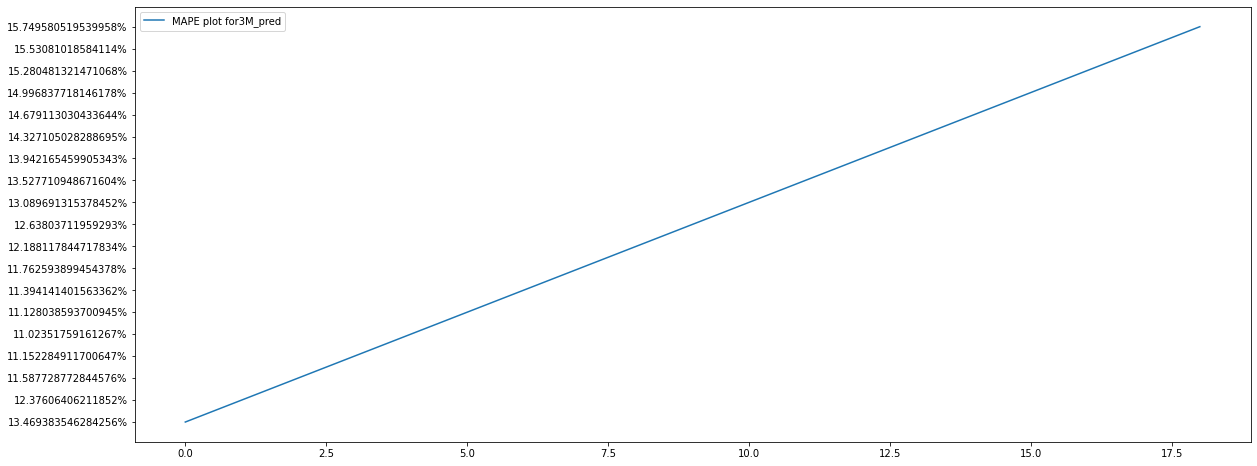

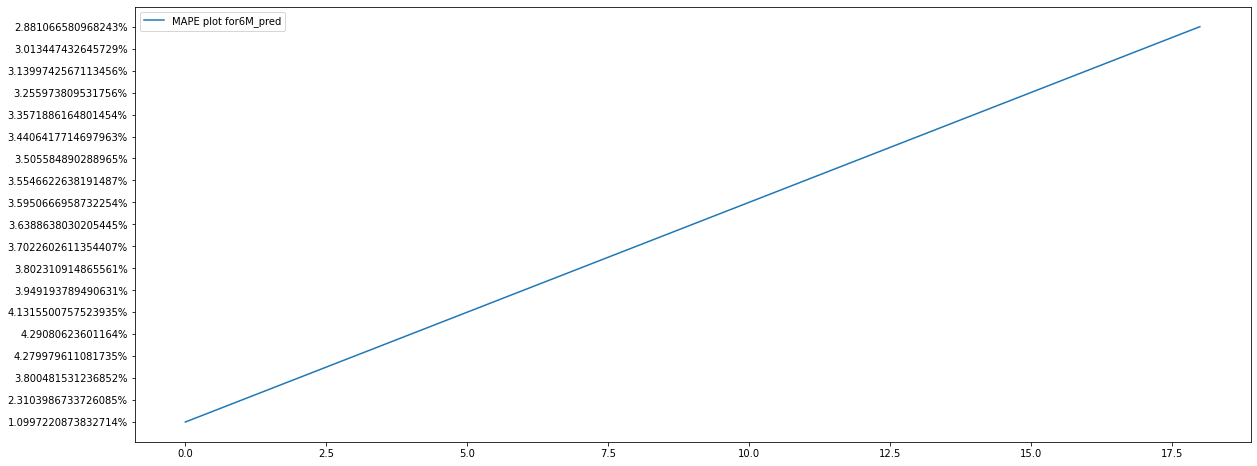

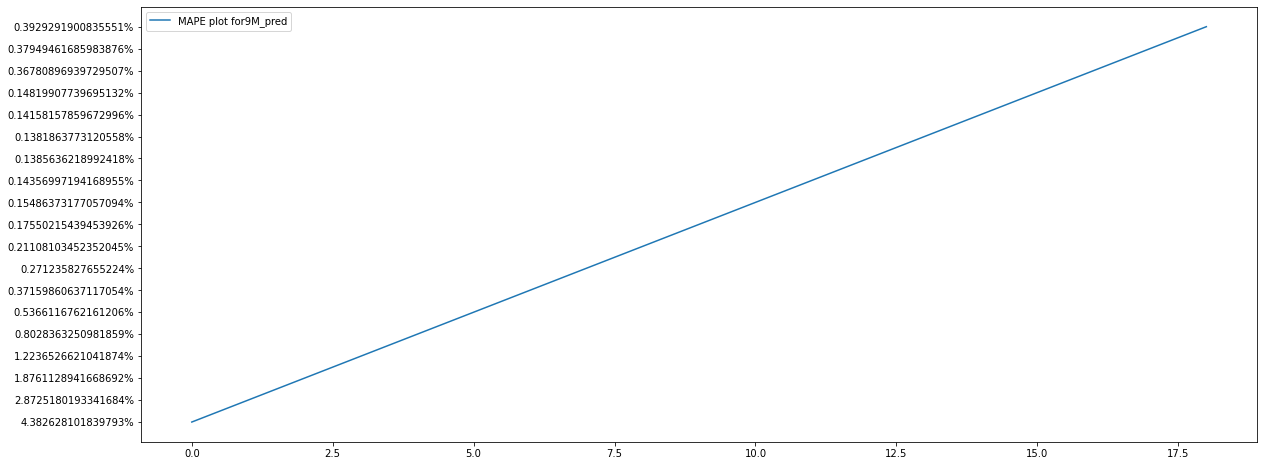

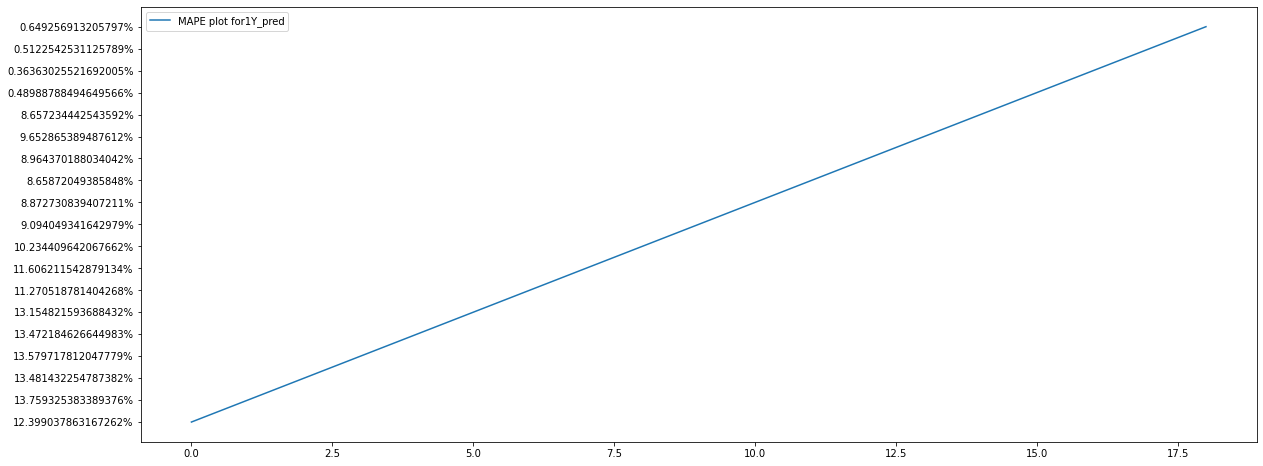

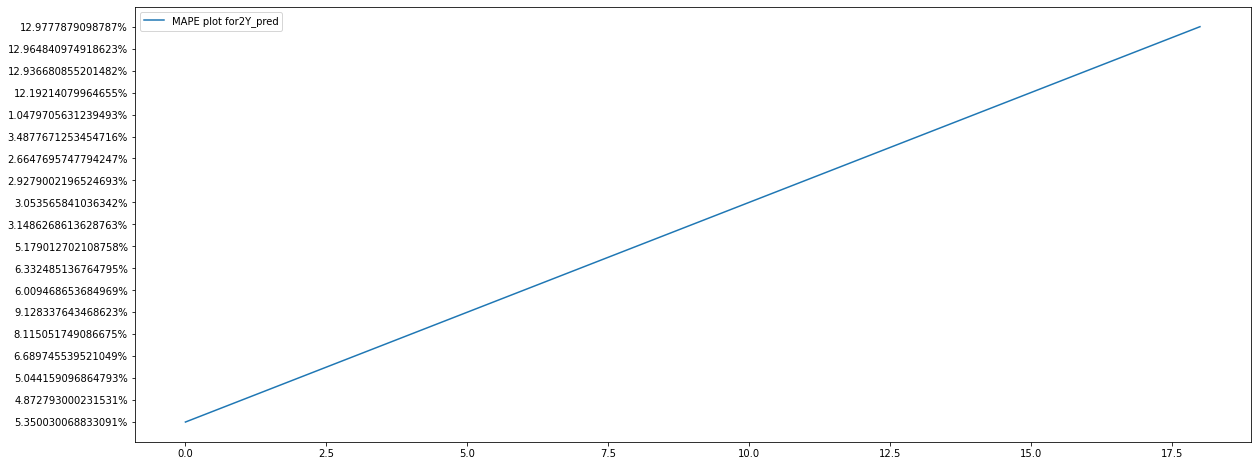

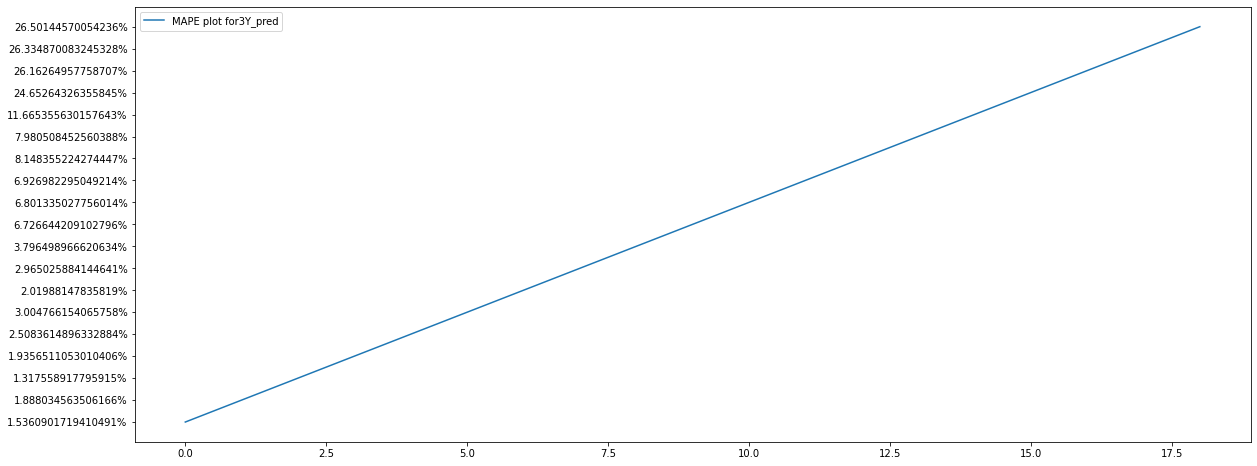

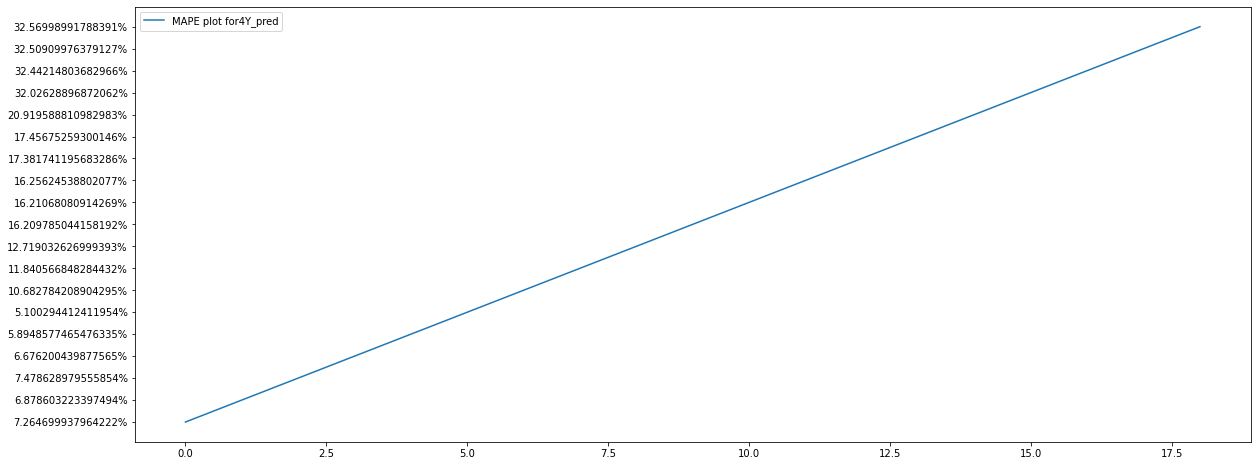

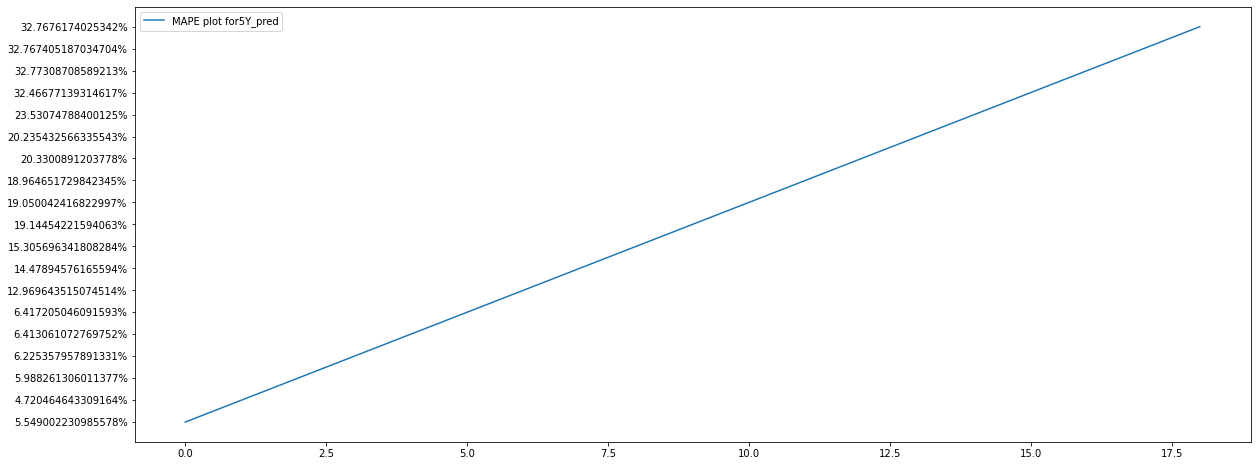

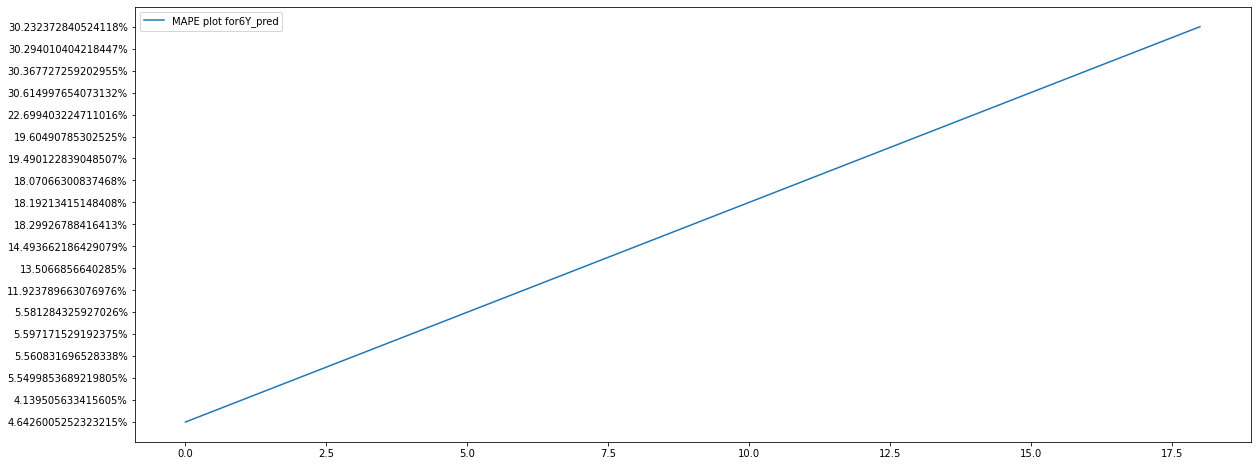

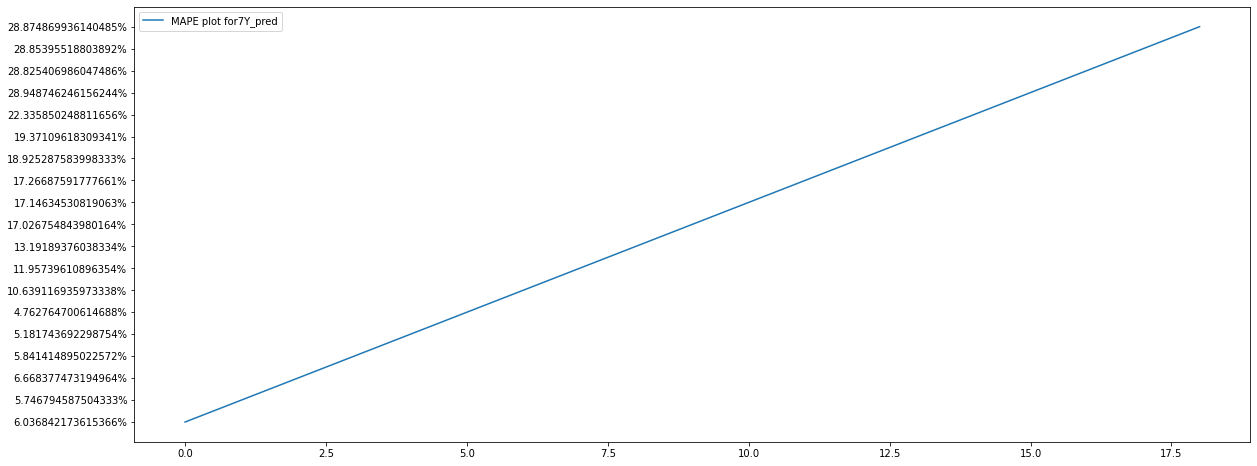

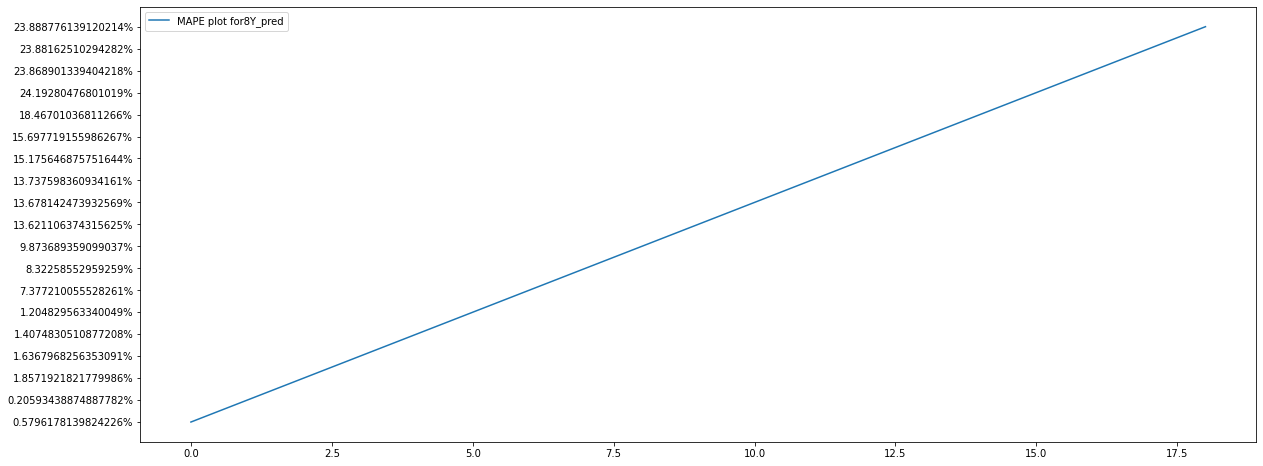

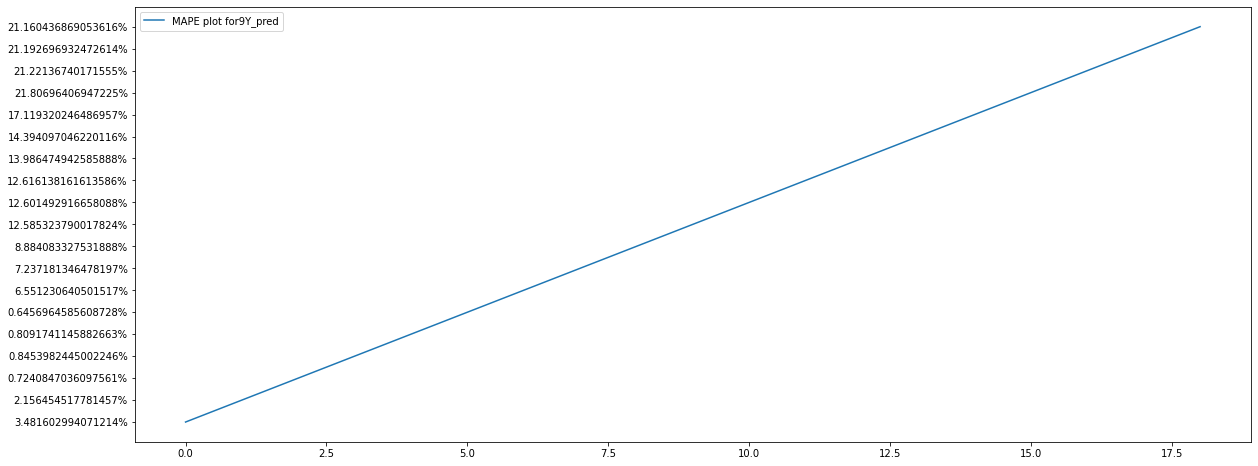

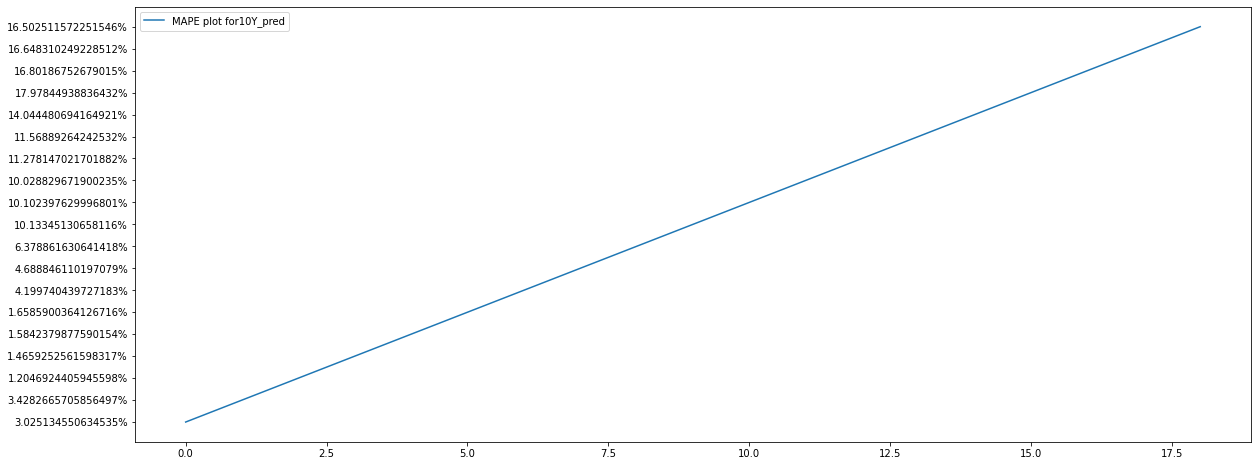

In [242]:
plot_errors(Xtest,X_input,path1,model1)

In [243]:
errors(X_test,X_input,path1,model1,output)

1M_pred 1M
Bias: 0.000167
Mean absolute error: 0.0001665347094598568
Mean squared error: 2.84309185729414e-08
Root mean squared error: 0.00016861470449798085
2M_pred 2M
Bias: -0.000265
Mean absolute error: 0.0002646510854755576
Mean squared error: 7.998877429471943e-08
Root mean squared error: 0.0002828228673476023
3M_pred 3M
Bias: -0.000575
Mean absolute error: 0.0005752973101640998
Mean squared error: 3.356827896413216e-07
Root mean squared error: 0.0005793813853079175
6M_pred 6M
Bias: 0.000184
Mean absolute error: 0.00019083966867704136
Mean squared error: 3.805979987668038e-08
Root mean squared error: 0.00019508921004678957
9M_pred 9M
Bias: 0.000046
Mean absolute error: 4.5938645499317036e-05
Mean squared error: 6.329331101285855e-09
Root mean squared error: 7.955709334362245e-05
1Y_pred 1Y
Bias: -0.000397
Mean absolute error: 0.0004079121307255845
Mean squared error: 2.110872296364958e-07
Root mean squared error: 0.0004594423028373593
2Y_pred 2Y
Bias: -0.000029
Mean absolute error

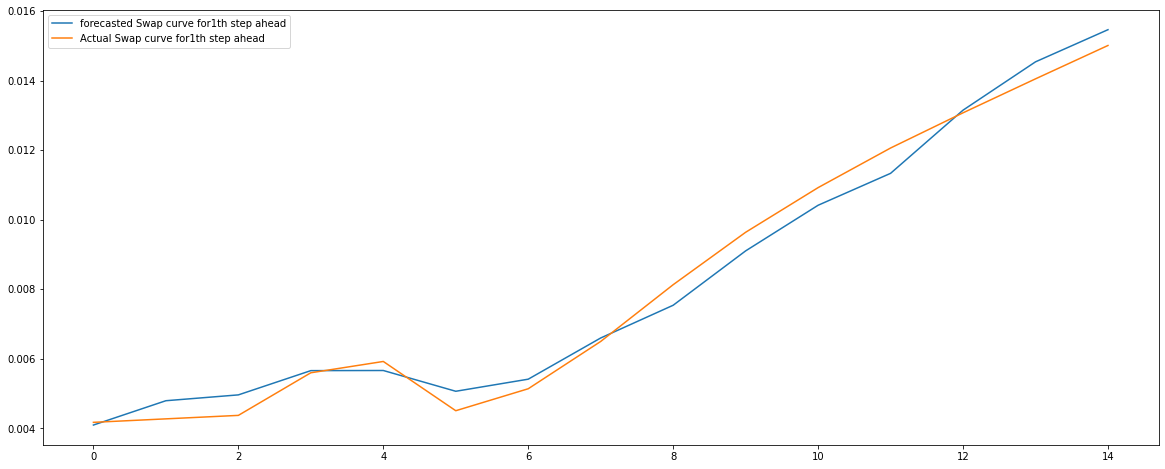

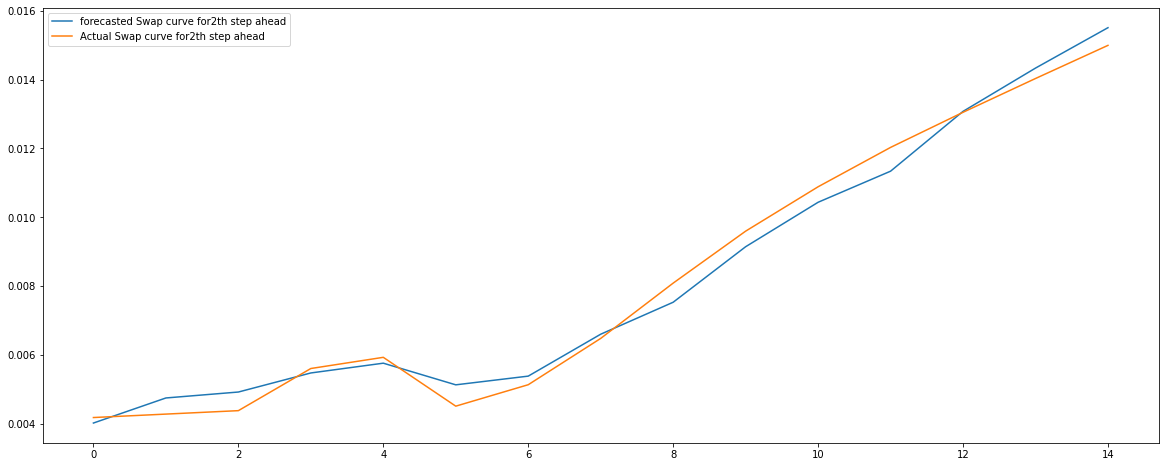

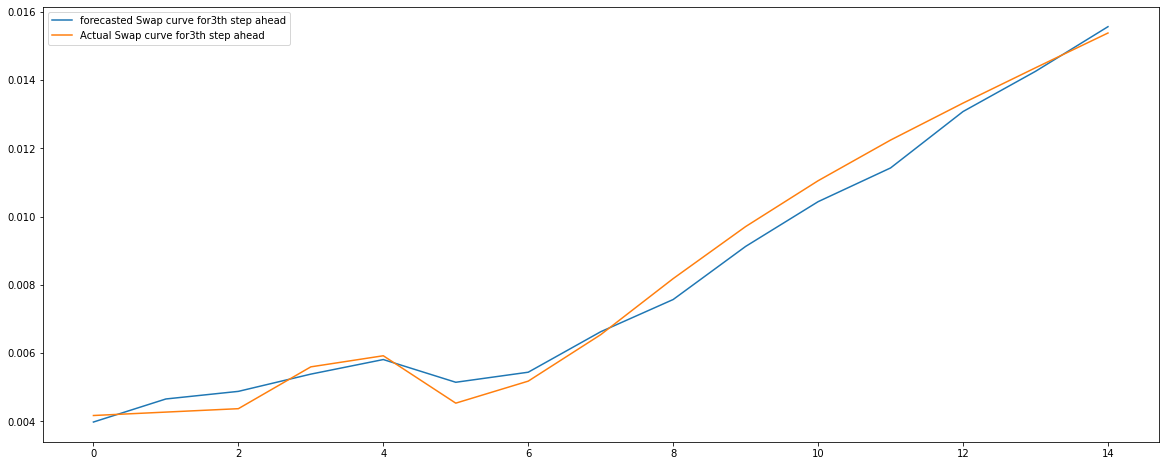

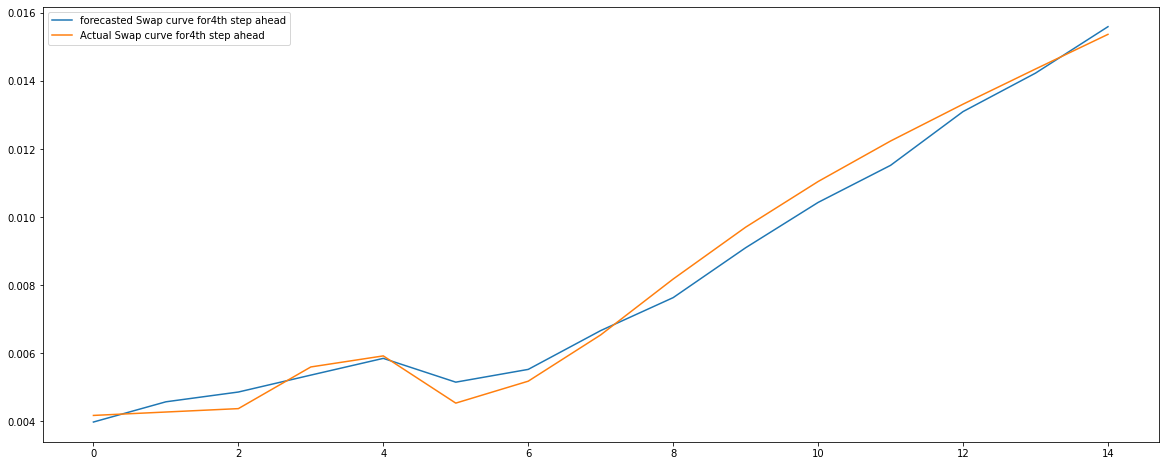

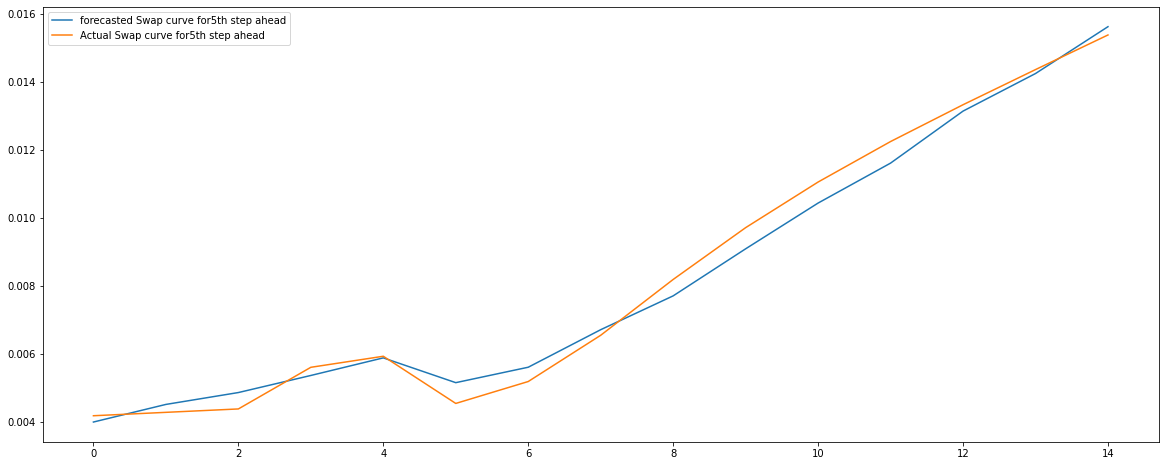

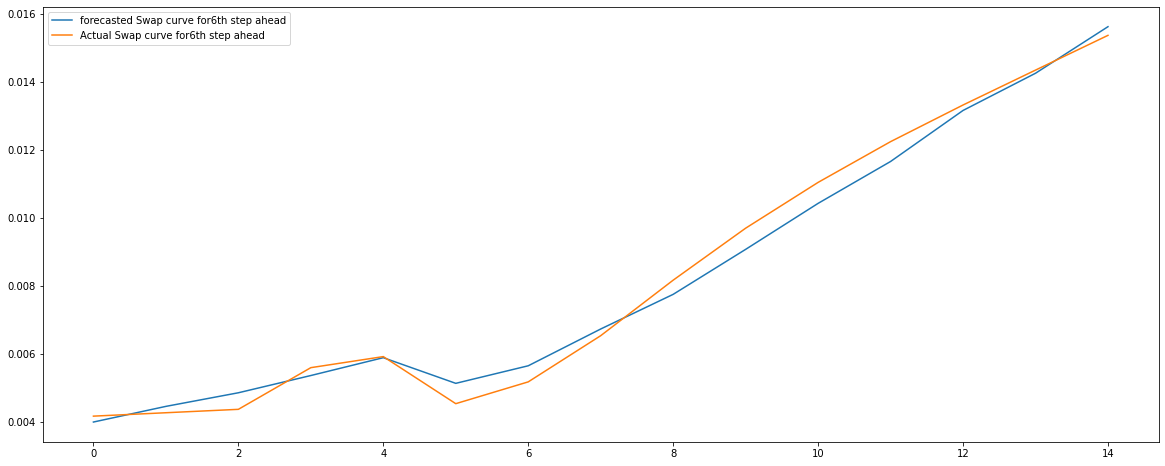

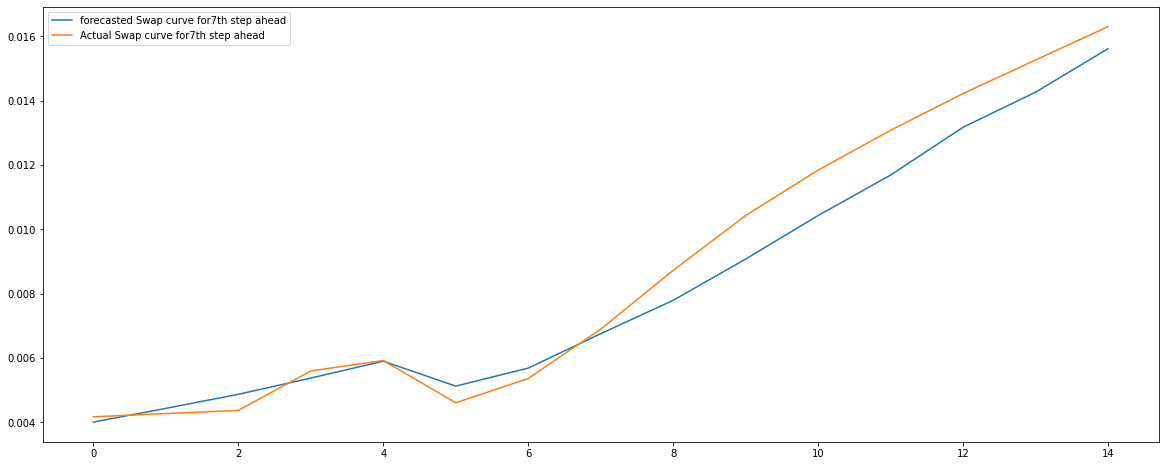

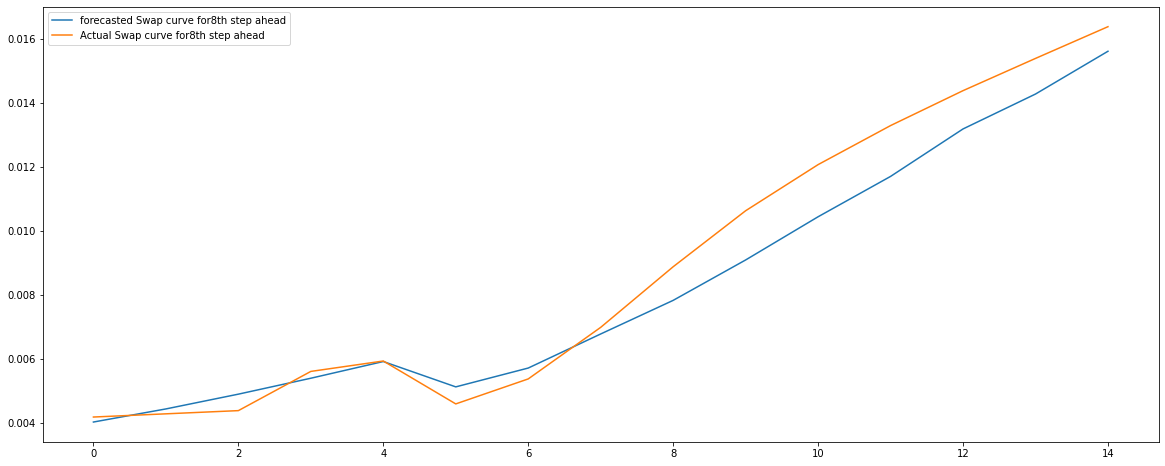

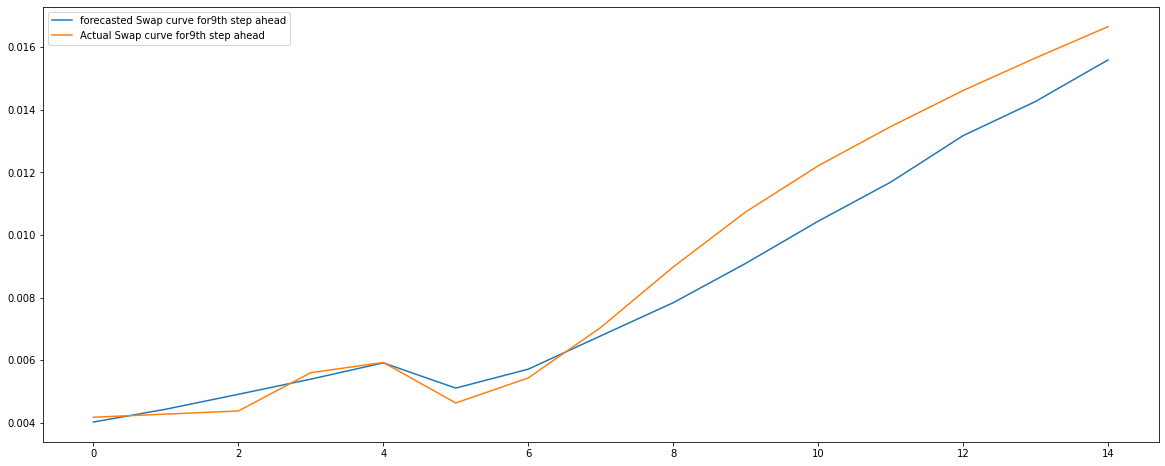

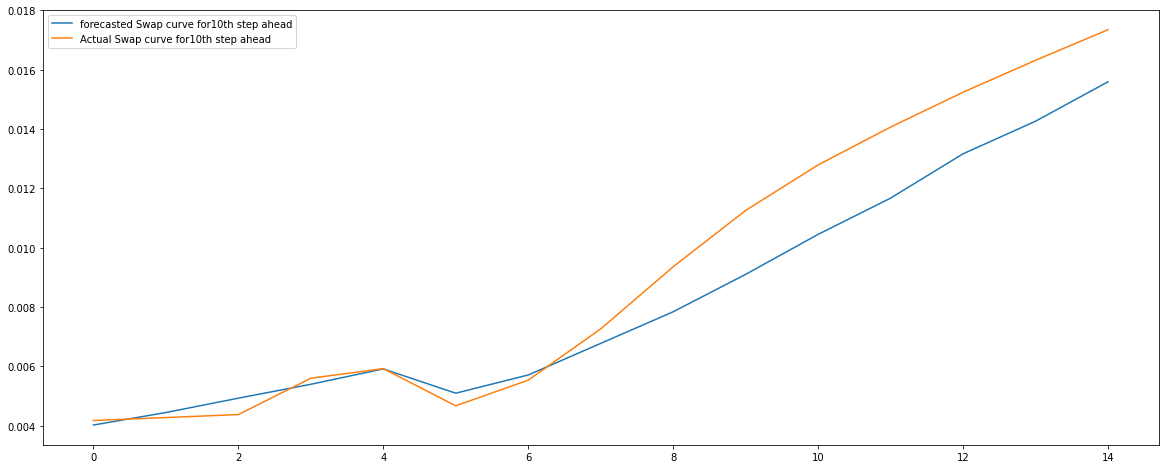

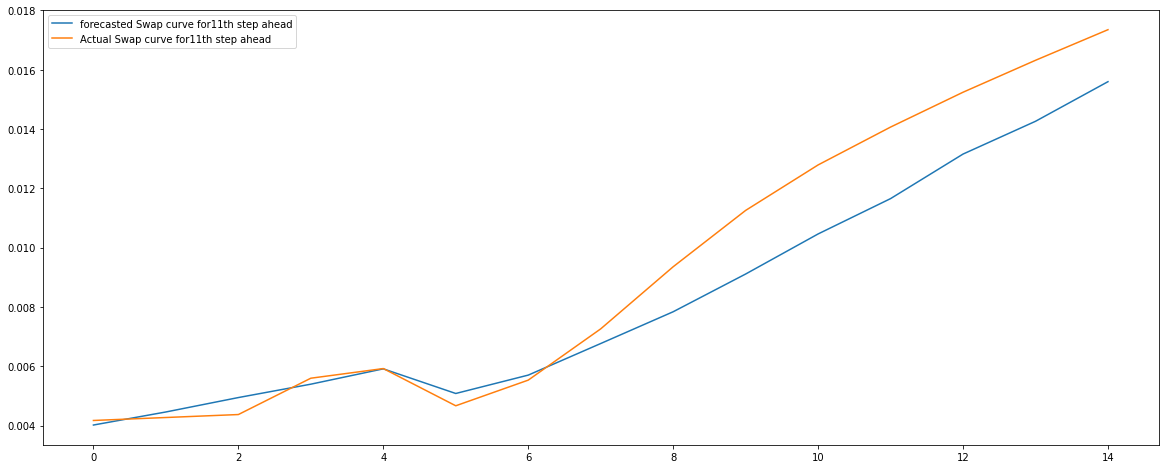

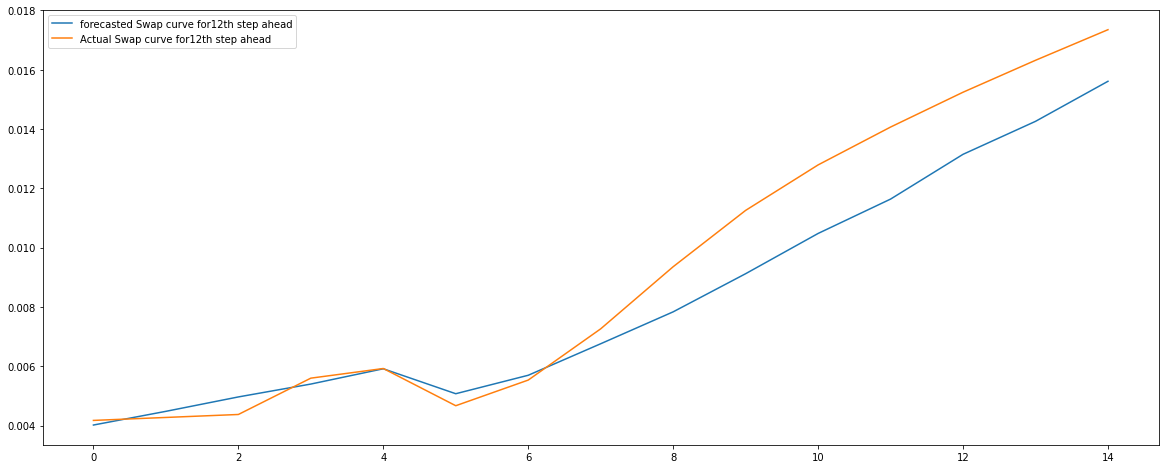

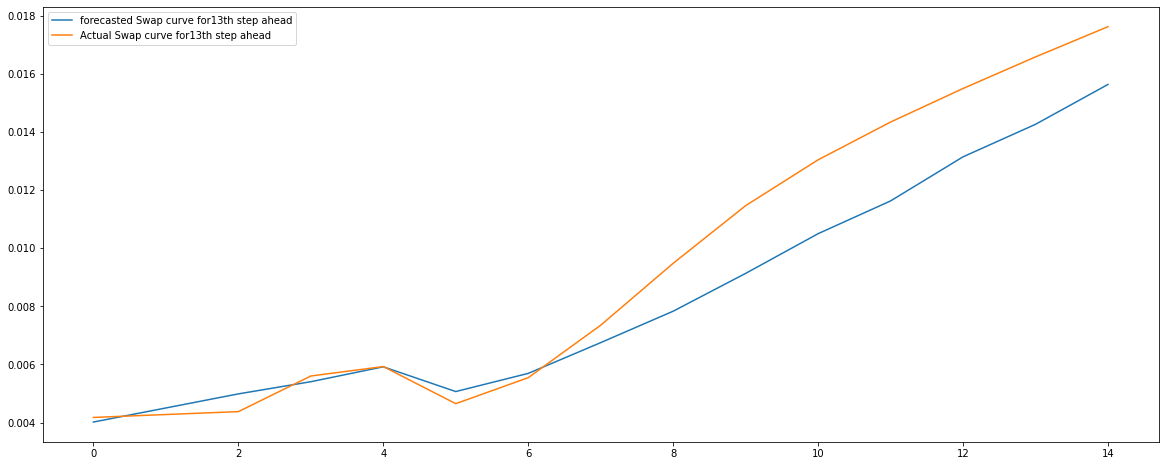

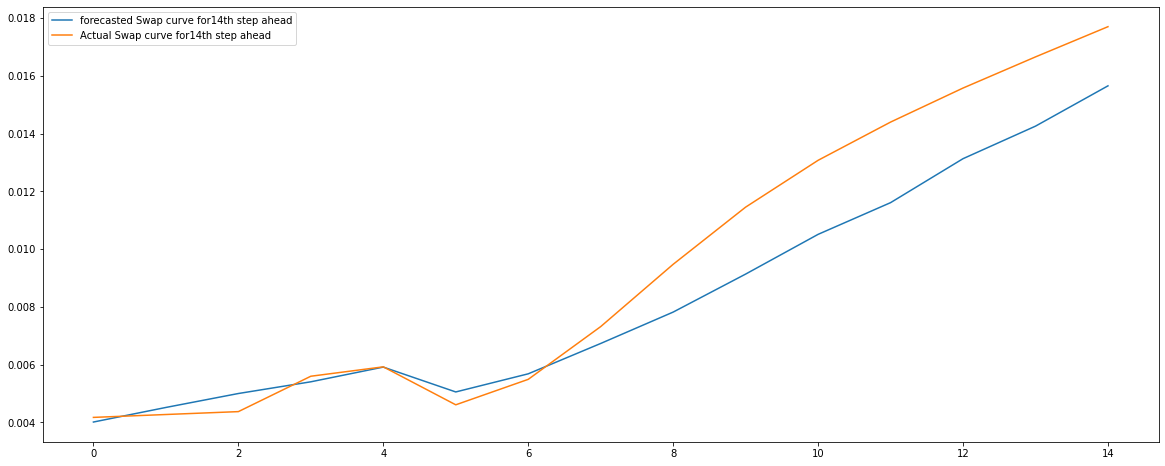

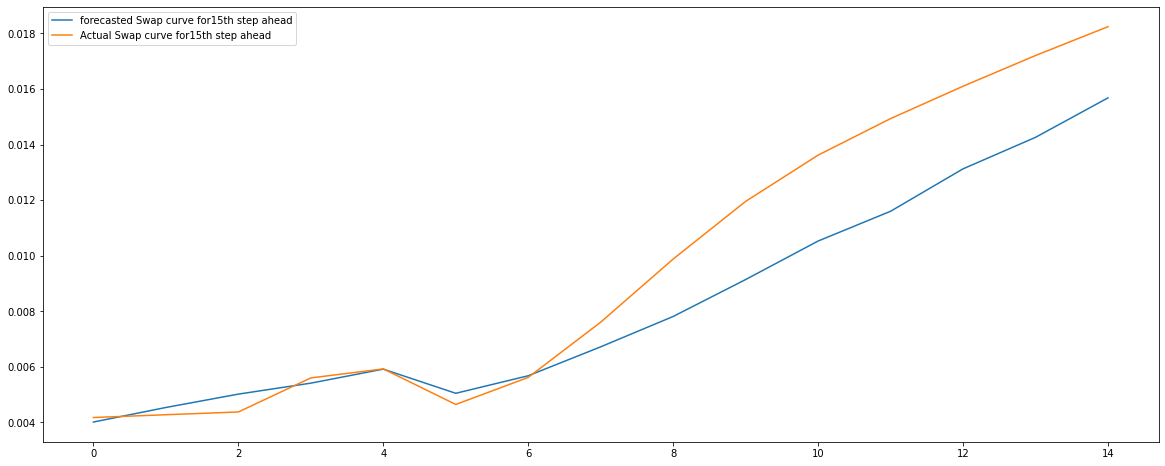

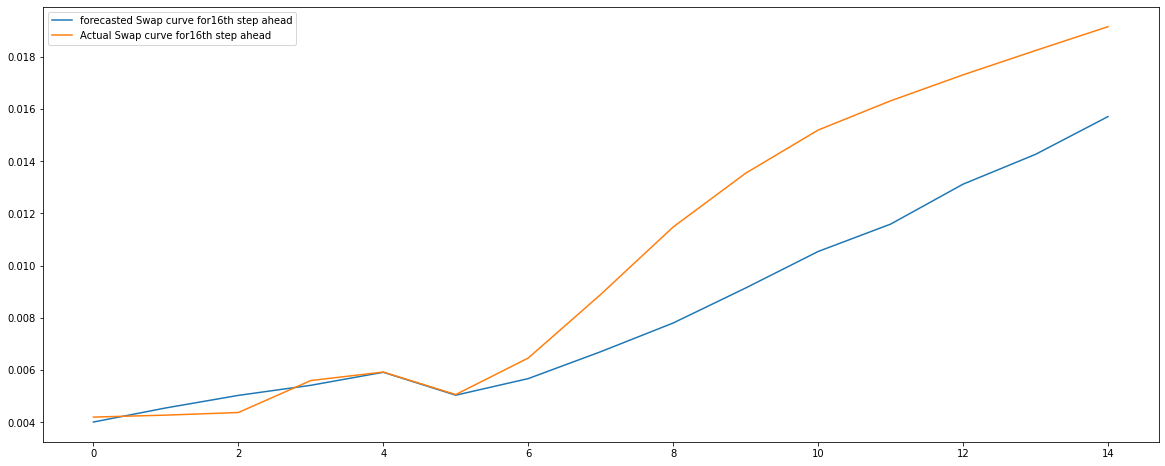

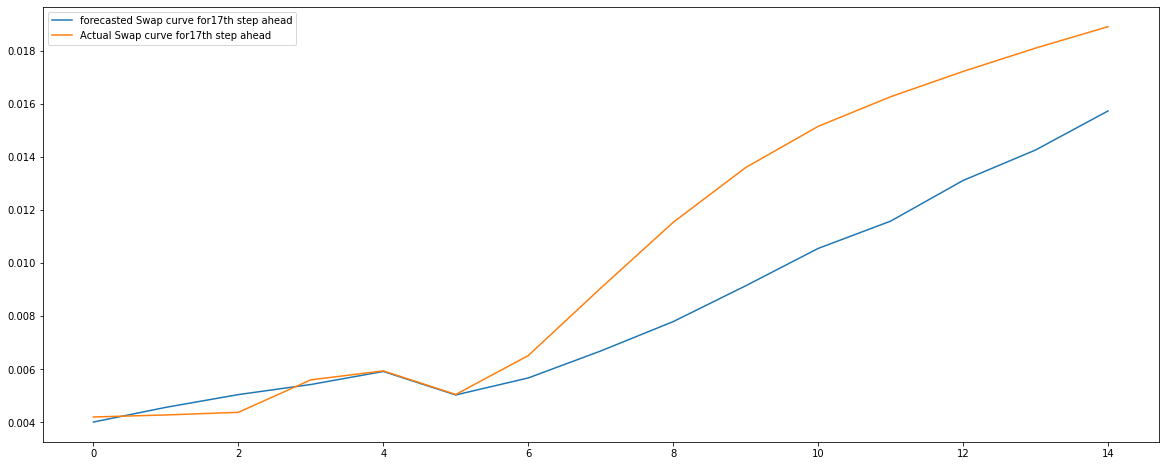

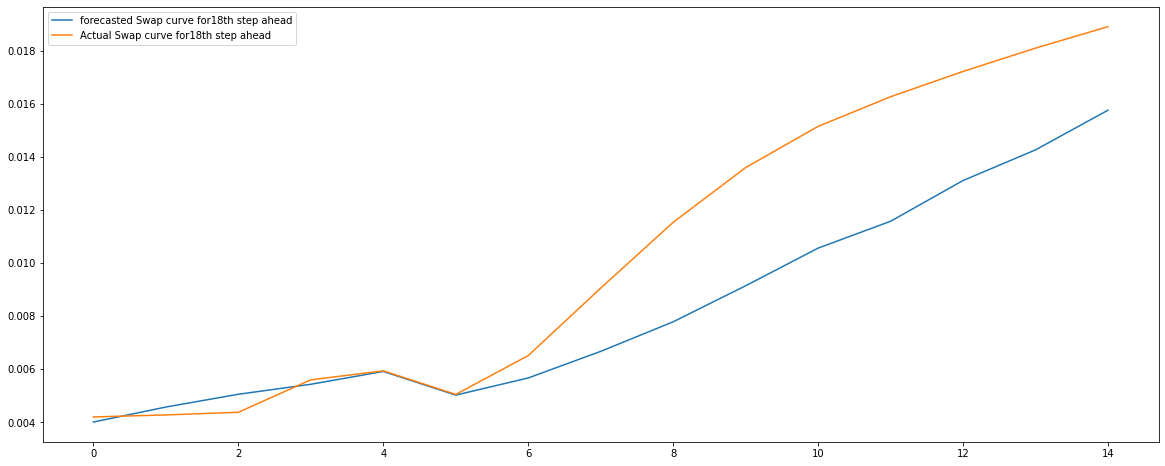

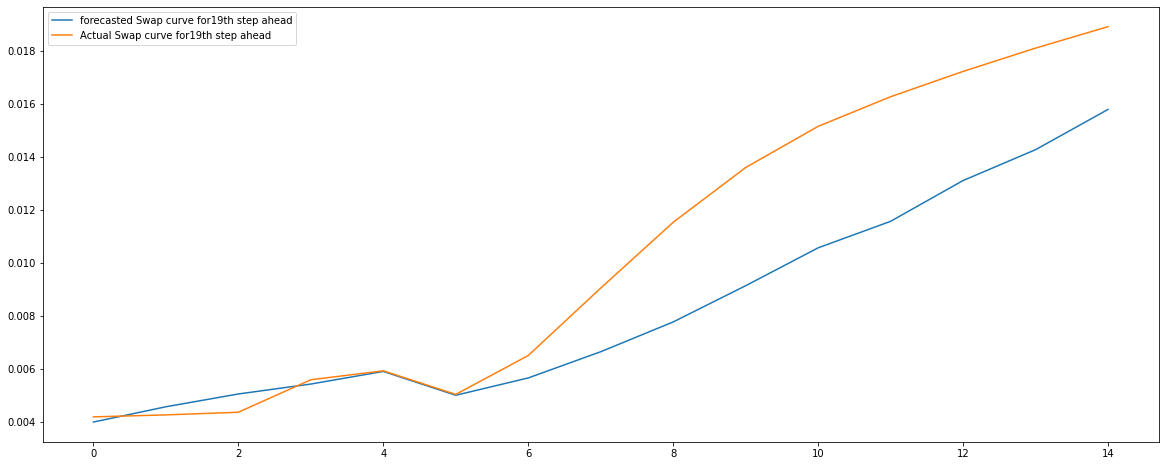

In [208]:
plot_SwapCurves(output,X_test)

## Mean Absolute Error with increasing time steps

In [245]:
mae=[]
for i in range(steps_ahead):
    mae.append(mean_absolute_error(output.iloc[i],X_test.iloc[i]))  
ser = go.Scatter(x=np.arange(1,steps_ahead+1),
                         y=mae)
layout = go.Layout(title='Mean Absolute Error with increasing steps', xaxis=dict(title='Steps'),
                   yaxis=dict(title='MAE'))

fig = go.Figure(data=[ser], layout=layout)
py.iplot(fig, sharing='public')

## Mean Squared Error with increasing maturity

In [246]:
mae_maturity=[]
for i in range(n_features):
    mae_maturity.append(mean_absolute_error(output.iloc[:,i:i+1],X_test.iloc[:,i:i+1])) 
ser = go.Scatter(x=output.columns,
                         y=mae)
layout = go.Layout(title='Mean Absolute Error with increasing maturity', xaxis=dict(title='Maturity'),
                   yaxis=dict(title='MAE'))

fig = go.Figure(data=[ser], layout=layout)
py.iplot(fig, sharing='public')

## Forecasting the final Swap Curve for 19th March 2021 using the entire data.

Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 30, 15)]     0                                            
__________________________________________________________________________________________________
lstm_88 (LSTM)                  [(None, 150), (None, 99600       input_39[0][0]                   
__________________________________________________________________________________________________
repeat_vector_38 (RepeatVector) (None, 19, 150)      0           lstm_88[0][0]                    
__________________________________________________________________________________________________
lstm_89 (LSTM)                  (None, 19, 150)      180600      repeat_vector_38[0][0]           
                                                                 lstm_88[0][1]             

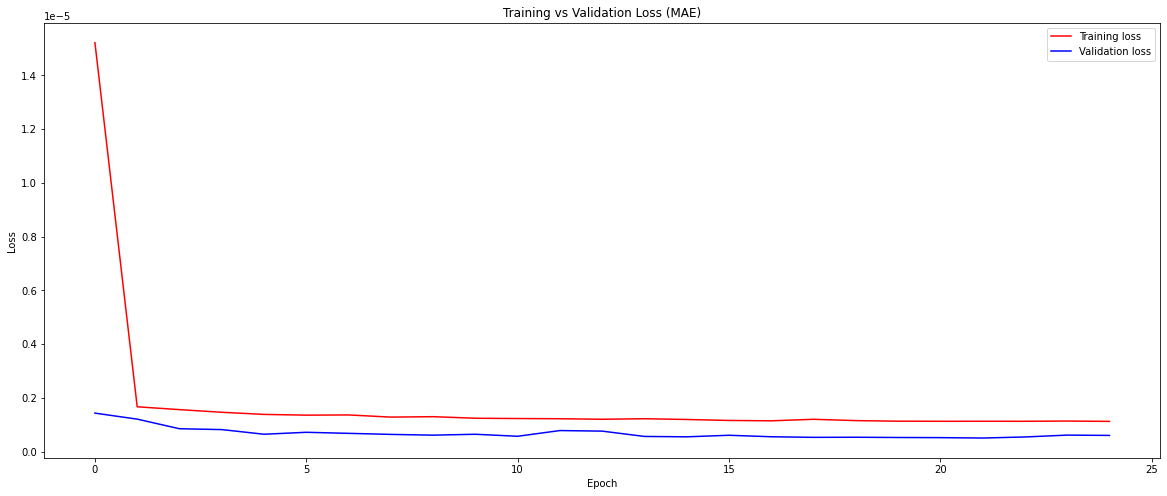

In [249]:
lag = 30
steps_ahead = 19
n_features = 15

train,val = df[1:7500], df[7500:]

path1="best_weights1.hdf5"

model1=model1(lag, steps_ahead, n_features)

training(lag,steps_ahead,n_features,model1,path1,train,val)

In [250]:
model1.load_weights(path1)
X_input=df[-(lag):].values
X_input=X_input.reshape(1,lag,n_features)
fina_pred=model1.predict(X_input)

In [251]:
fina_pred=fina_pred.reshape(fina_pred.shape[1],fina_pred.shape[2])
c1=['1M_pred', '2M_pred', '3M_pred', '6M_pred', '9M_pred', '1Y_pred',
       '2Y_pred', '3Y_pred', '4Y_pred', '5Y_pred', '6Y_pred', '7Y_pred',
       '8Y_pred', '9Y_pred', '10Y_pred']
fina_pred = pd.DataFrame(fina_pred)
fina_pred.columns=c1

In [252]:
fina_pred.index=pd.date_range(start="2021-03-01",end="2021-03-19")
#fina_pred

In [253]:
series_1m= df["1M"]
ser = go.Scatter(x=fina_pred.columns,
                         y=fina_pred[-1:].values[0])
layout = go.Layout(title='Forecast for 19th March', xaxis=dict(title='Maturities'),
                   yaxis=dict(title='(swap rates)'))

fig = go.Figure(data=[ser], layout=layout)
py.iplot(fig, sharing='public')

In [254]:
fina_pred[-1:]

,1M_pred,2M_pred,3M_pred,6M_pred,9M_pred,1Y_pred,2Y_pred,3Y_pred,4Y_pred,5Y_pred,6Y_pred,7Y_pred,8Y_pred,9Y_pred,10Y_pred
2021-03-19,0.003727,0.004368,0.004726,0.005018,0.005708,0.005515,0.007337,0.009367,0.011061,0.012575,0.01414,0.015209,0.01676,0.017677,0.019265


# Inferences:
## Statistical vs Encoder-Decoder Approach

### Comparing the errors: 

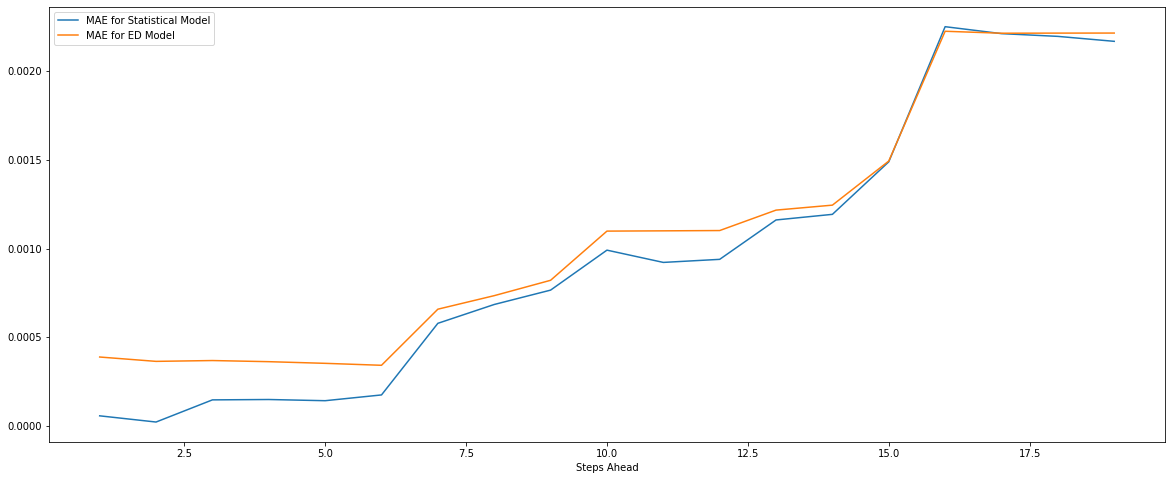

In [230]:
mae_stat=[5.662635839578442e-05,2.166635002200853e-05,0.00014659012092001583,0.0001486634612196854, 0.0001419201214213561,
 0.0001744392649622803,0.0005782504564898105,0.0006844137135564018, 0.0007654192487177609,0.0009908055646503887,
 0.000921630234624162,0.0009388956767221569, 0.0011609813897656826,0.0011926239413951134,
 0.0014887728956024327,0.0022506899294570267, 0.0022115187837263867,0.002196063143475188,0.002168125860126351]
plt.plot(np.arange(1,20),mae_stat,label="MAE for Statistical Model")
plt.plot(np.arange(1,20),mae,label="MAE for ED Model")
plt.xlabel("Steps Ahead")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [232]:
print("The MAE obtained using Encoder-Decoder is",np.asarray(mae).mean())
print("The MAE obtained using Statistical Modelling is ",np.asarray(mae_stat).mean())
print("Statistical Modelling performed ", 
      np.abs(np.asarray(mae).mean()-np.asarray(mae_stat).mean())/np.asarray(mae).mean()*100,
      "% better than the Encoder decoder method")

The MAE obtained using Encoder-Decoder is 0.001079501590155529
The MAE obtained using Statistical Modelling is  0.000959899816592105
Statistical Modelling performed  11.079351309356786 % better than the Encoder decoder method
